In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import random
import time

import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.stats as stats

In [2]:
ds = xr.open_dataset('data1/pr_hyras_1_1931_v6-1_de.nc', engine='netcdf4')

In [27]:
ds

<xarray.Dataset> Size: 874MB
Dimensions:             (time: 365, bnds: 2, y: 890, x: 665)
Coordinates:
  * time                (time) datetime64[ns] 3kB 1931-01-01T06:00:00 ... 193...
    lon                 (y, x) float64 5MB ...
    lat                 (y, x) float64 5MB ...
  * x                   (x) float64 5kB 4.022e+06 4.022e+06 ... 4.686e+06
  * y                   (y) float64 7kB 2.674e+06 2.676e+06 ... 3.564e+06
Dimensions without coordinates: bnds
Data variables:
    time_bnds           (time, bnds) datetime64[ns] 6kB ...
    crs                 int32 4B ...
    pr                  (time, y, x) float32 864MB ...
    number_of_stations  (time) float64 3kB ...
    x_bnds              (x, bnds) float64 11kB ...
    y_bnds              (y, bnds) float64 14kB ...
Attributes: (12/22)
    source:                    surface observations
    institution:               Deutscher Wetterdienst (DWD)
    Conventions:               CF-1.11
    realization:               v6-1
    version_hyras_background:  v6-1
    project_id:                HYRAS
    ...                        ...
    input_data_status:         checked
    creation_date:             2025-07-04T03:48:43Z
    filename:                  pr_hyras_1_1931_v6-1_de.nc
    unique_dataset_id:         DWD_HYRAS_DE_1km_pr_v6-1_1931_day_0068674F1B
    product:                   observations
    realm:                     atmos

In [21]:
a = torch.rand(100,1,10,20,20)
b = torch.rand(100,20,20)

In [3]:
time_depth = 11
y_height = 20
x_width = 20

In [4]:
shape = ds['pr'].shape 
amount = 15000

In [5]:
inds = np.vstack((np.random.randint(0, shape[0]-time_depth, amount),
            np.random.randint(int(shape[1] / 3), int(shape[1] * 2 / 3), amount),
            np.random.randint(int(shape[2] / 6), int(shape[2] * 5 / 6), amount),)).T

In [6]:
batch = []

for ind in inds:

    t = slice(ind[0], ind[0] + time_depth)
    y = slice(ind[1], ind[1] + y_height)
    x = slice(ind[2], ind[2] + x_width)

    batch.append(ds['pr'][t, y, x].fillna(0).compute().values)

hist = np.concatenate(batch).flatten()

In [7]:
hist_1 = hist.copy()

In [164]:
hist_2 = hist.copy()

In [168]:
hist_3 = hist.copy()

In [9]:
old_weights = 1 / pd.Series(hist_1).value_counts().sort_index()

In [10]:
limit = np.percentile(hist_1, 99.999)

In [11]:
keys = np.linspace(0, 200, 2001)
weights = np.array([])

for k in keys:

    if k < limit:
        if k  in old_weights.index:
            weights = np.append(weights, old_weights[k])

        else:
            next_val = old_weights[k:].index[0]
            weights = np.append(weights, (old_weights[k-0.1] + old_weights[next_val]) / 2)
    
    else:
        weights = np.append(weights, old_weights[limit])
        
weights = np.clip(weights, None, old_weights[limit])

In [399]:
weights = torch.from_numpy(np.vstack((keys, weights)))

In [12]:
weights

array([3.37720012e-08, 3.09414270e-07, 4.96255012e-07, ...,
       3.33333333e-01, 3.33333333e-01, 3.33333333e-01])

In [ ]:
weights[np.searchsorted(keys, [0.1,1.1])]

In [34]:
scaled_weights = (weights - weights.max()) / 1.005 + weights.max()

In [30]:
w_min, w_max = weights.min(), weights.max()
new_min, new_max = 1e-4, weights.max()

# logarithmic rescaling
new_weights = 10 ** (
    (np.log10(weights) - np.log10(w_min)) / (np.log10(w_max) - np.log10(w_min)) *
    (np.log10(new_max) - np.log10(new_min)) + np.log10(new_min) 
     
)

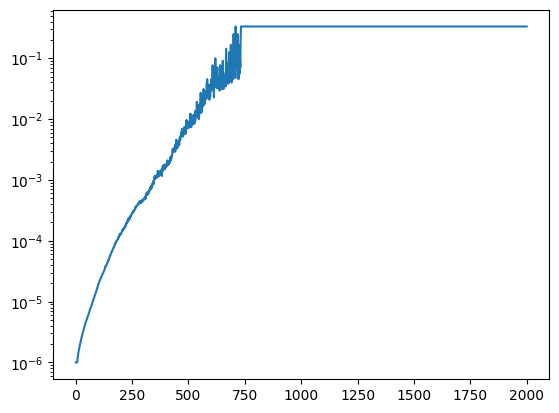

In [37]:
plt.semilogy(np.clip(weights, 1e-6, old_weights[limit]))
plt.show()

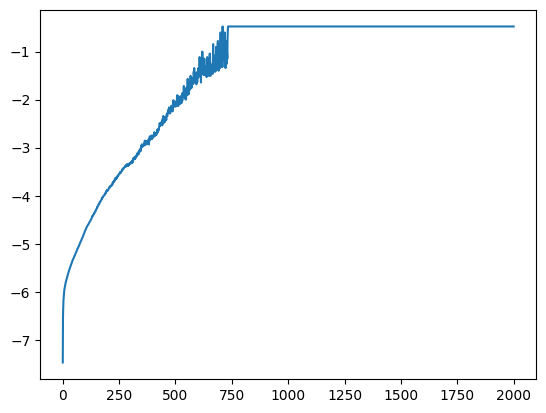

In [36]:
plt.plot(np.log10(weights))
plt.show()

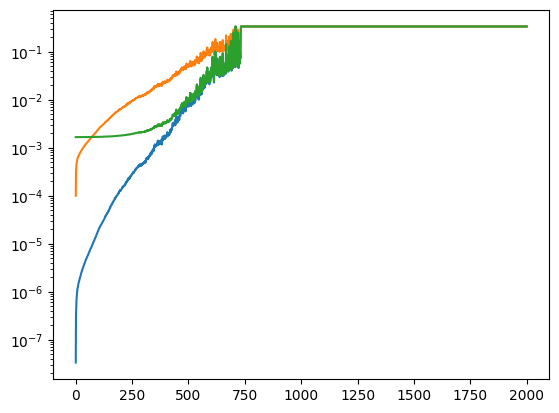

In [35]:
plt.semilogy(weights)
plt.semilogy(new_weights)
plt.semilogy(scaled_weights)
plt.show()

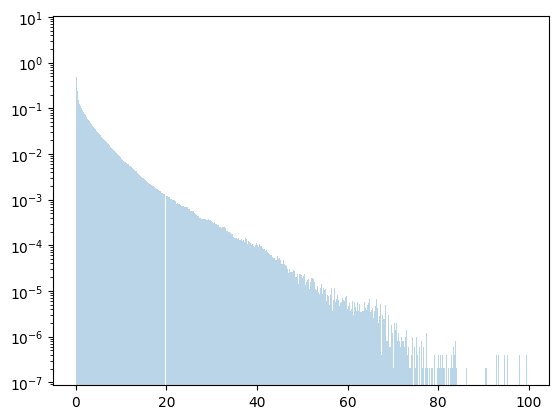

In [251]:
arr1, arr2, axs = plt.hist(hist_1[hist_1 <= 100], bins=1000, log=True, density=True, alpha=0.3)

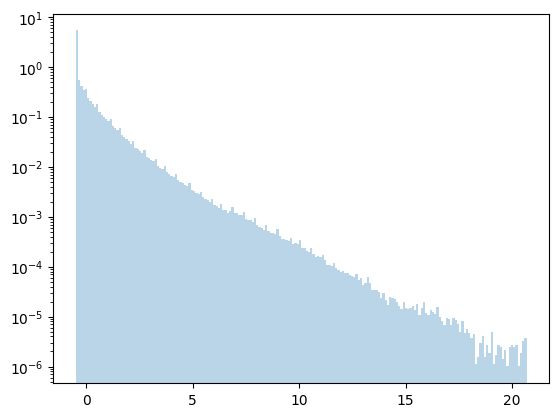

In [151]:
plt.hist((hist_1 - hist_1.mean()) / hist_1.std(), bins=200, log=True, density=True, alpha=0.3)
#plt.hist(hist_2, bins=200, log=True, density=True, alpha=0.3)
#plt.hist(hist_3, bins=200, log=True, density=True, alpha=0.3)
plt.show()

In [10]:
ds.isel(x=500, y=500, time=0).values

<bound method Mapping.values of <xarray.Dataset> Size: 80B
Dimensions:             (bnds: 2)
Coordinates:
    time                datetime64[ns] 8B 1931-01-01T18:00:00
    lon                 float64 8B ...
    lat                 float64 8B ...
    x                   float32 4B 4.306e+06
    y                   float32 4B 2.986e+06
Dimensions without coordinates: bnds
Data variables:
    time_bnds           (bnds) datetime64[ns] 16B ...
    x_bnds              (bnds) float32 8B ...
    y_bnds              (bnds) float32 8B ...
    crs                 int32 4B ...
    pr                  float32 4B ...
    number_of_stations  float64 8B ...
Attributes: (12/22)
    source:                    surface observations
    institution:               Deutscher Wetterdienst (DWD)
    realization:               v6.0
    version_hyras_background:  v6.0
    project_id:                HYRAS
    level_type:                surface
    ...                        ...
    conventionsURL:            http

In [72]:
ds.isel(x=2, y=0, time=1, bnds=0).pr.values

array(nan, dtype=float32)

In [18]:
data = xr.DataArray(np.random.randn(2, 3), dims=("x", "y"), coords={"x": [10, 20]})
data

<xarray.DataArray (x: 2, y: 3)> Size: 48B
array([[ 0.70790352,  1.32302453, -0.05076007],
       [ 0.43076802,  0.12503611, -1.26461207]])
Coordinates:
  * x        (x) int32 8B 10 20
Dimensions without coordinates: y

In [21]:
data[:,0]

<xarray.DataArray (x: 2)> Size: 16B
array([0.70790352, 0.43076802])
Coordinates:
  * x        (x) int32 8B 10 20

In [2]:
x = np.array([1,3])
y = np.array([1,8])

In [4]:
f = np.polyfit(x,y,10)

C:\Users\anton\AppData\Local\Temp\ipykernel_13588\2406769207.py:1: RankWarning: Polyfit may be poorly conditioned
  f = np.polyfit(x,y,10)


In [5]:
def poly_func(f, x):
    y = np.zeros(x.shape)
    for i in range(len(f)):
        y += f[i] * x ** (len(f)-i-1)
    return y

In [6]:
x_poly = np.linspace(-5,5, 100)
y_poly = poly_func(f, x_poly)

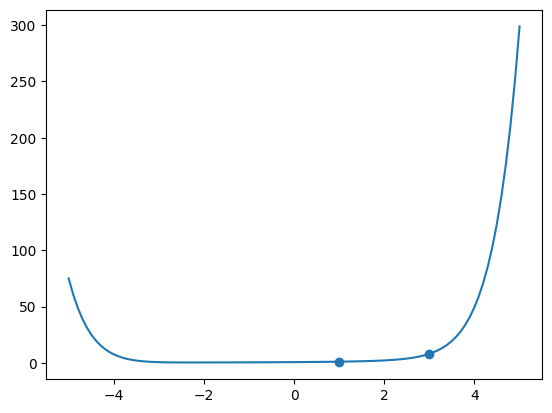

In [7]:
plt.scatter(x,y)
plt.plot(x_poly, y_poly)
plt.show()

In [ ]:
for i in model.parameters():
    print(i)

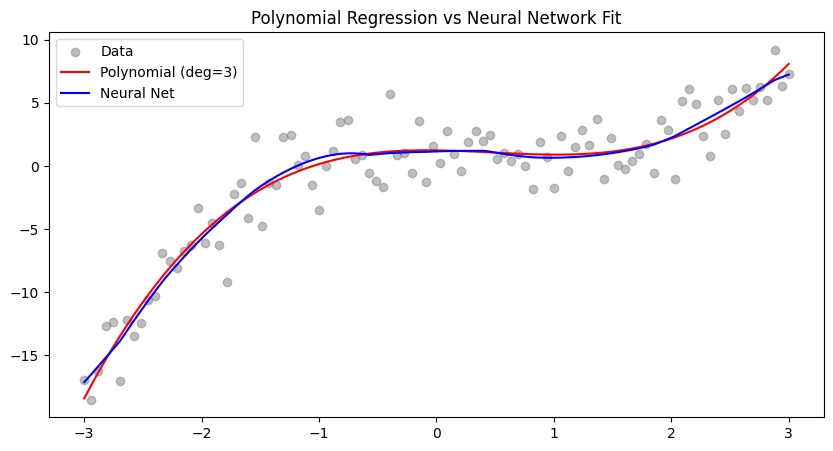

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn
import torch.optim as optim

# Generate synthetic 1D data
np.random.seed(0)
x = np.linspace(-3, 3, 100).reshape(-1, 1)
y_true = 0.5 * x**3 - x**2 + 2 + np.random.normal(0, 2, size=x.shape)

# ----- Polynomial Regression -----
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(x)
poly_reg = LinearRegression().fit(X_poly, y_true)
y_poly_pred = poly_reg.predict(X_poly)

# ----- Neural Network Regression -----
# Convert to torch tensors
X_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y_true, dtype=torch.float32)

# Define simple neural net
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 128),
            nn.SELU(),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.layers(x)

model = SimpleNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train NN
for epoch in range(1000):
    optimizer.zero_grad()
    output = model(X_tensor)
    loss = criterion(output, y_tensor)
    loss.backward()
    optimizer.step()

# Predictions
y_nn_pred = model(X_tensor).detach().numpy()

# ----- Plot results -----
plt.figure(figsize=(10, 5))
plt.scatter(x, y_true, color="gray", alpha=0.5, label="Data")
plt.plot(x, y_poly_pred, color="red", label="Polynomial (deg=3)")
plt.plot(x, y_nn_pred, color="blue", label="Neural Net")
plt.legend()
plt.title("Polynomial Regression vs Neural Network Fit")
plt.show()
